# Economic Complexity of Australian Regions

Hamish Gamble [](https://orcid.org/0000-0003-1277-1227) (Flinders University)  
Sharif Rasel (Flinders University)  
July 23, 2024

## Introduction

## Literature Review

@hidalgo2009 introduced the concept of economic complexity as a means of quantifying and explaining differences in the economic development trajectory of different countries. Their method used bilateral trade data to identify the network structure of countries and the products they export and built on the concept of relatedness introduced in @hidalgo2007. Economic complexity has been shown to be a positive predictor of Gross Domestic Product (GDP), and GDP growth. Increasing economic complexity has also been shown to decrease unemployment and increase employment @adam2023, reduce green house gas emissions @romero2021 and reduce income inequality @hartmann2017.

Relatedness has since been applied across industry \[@neffke2012\], research areas \[@guevara2016\], occupation \[@muneepeerakul2013\] and technology (patents) \[@kogler2013\].

The relatedness approach has also been used to quantify economic complexity across cities, states, and regions, using employment data\[@ecus, @ecnz, @ecmexico\], business counts\[@ecchina\], patent classifications \[@balland2021\], and interstate and international trade data \[@ecaus\].

Despite differences in data sources, the method for calculating economic complexity in the literature is relatively standard. The presence of an activity in a region is often identified using a location quotient method, such that an activity is said to be present in a region if:

$$\frac{X_a^r/\sum_{a}X_a^r}{\sum_{r}X_a^r/\sum_{r,a}X_a^r} \geq 1$$

Where $X$ is the measure of an activity $a$ in region $r$ - such as the level of employment in an occupation in a city, or the number of businesses classified in an industry in a province, or the value of exports of a product from a country. The location quotient method creates a binary matrix $M$ with $a$ rows and $r$ columns.

### Regional economic complexity of small areas

The location quotient method can be unreliable due to the discontinuity at 1. This is especially relevant when economic complexity is calculated in regional areas where either $X_a^r$ or $\frac{\sum_{r}X_a^r}{\sum_{r,a}X_a^r}$ are small. In these cases, small changes, or measurement error in $X_a^r$ can significantly change the location quotient.

The choice of region size and activity classification is important. In a study of the economic complexity of US regions, @ecus use metropolitan areas as the basis for calculations. Metropolitan areas in the United States are defined such that jobs within a given area are held by residents who live in that area.Metropolitan areas have a population of at least 50,000 people. The smallest MSA was estimated to have a 2023 population of 57,700 (about 0.015% of US population). They find a poor correlation between ECI calculated at higher level aggregated industry classifications indicating the importance of a high degree of disaggregation to provide as much information to the model as possible @ecus.

In New Zealand, @ecnz use weighted correlations of local employment shares. Regions range from a population of 1,434 to 573,150 with a mean population of 29,947 and median population of 6,952. Employment is measured as an industry-occupation pair.

-   Differences in relationship between complexity and relatedness on indicators may be entirely context dependent.

## Data & Methods

### Data

-   Calculate economic complexity indicators for Australian regions using employment data from the 2021 Census.

-   Regions classified by Statistical Areas Level 3 (SA3)

-   Economic activity classified by ANZSIC industry division and ANZSCO major group

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'economiccomplexity'

The following object is masked from 'package:stats':

    density

Linking to GEOS 3.12.1, GDAL 3.8.4, PROJ 9.3.1; sf_use_s2() is TRUE


Attaching package: 'tmap'

The following object is masked from 'package:datasets':

    rivers

Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

New names:
• `` -> `...6`

e.g.:
  dat <- vroom(...)
  problems(dat)

Rows: 99360 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): 1-digit level OCCP Occupation, SA3 (POW), 1-digit level INDP Indust...
dbl (1): Count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

-   We exclude individuals who identify their place of work as a Migratory - Offshore - Shipping region or as No Fixed Address. Employment in these regions totals 497,913 or about 4% of the total sample.

-   Following @ecnz, employment is aggregated into industry-occupation pairs, allowing for differentiation between, for example, managers working in agriculture, forestry, and fishing, and managers working in retail trade.

-   Dataset covers 340 regions and 152 industry-occupations. @fig-employment-density shows the presence of any level of employment within a region and industry-occupation. As can be seen, there is a high level of employment density across our data, with 88.5% of all combinations of region, industry, and occupation.

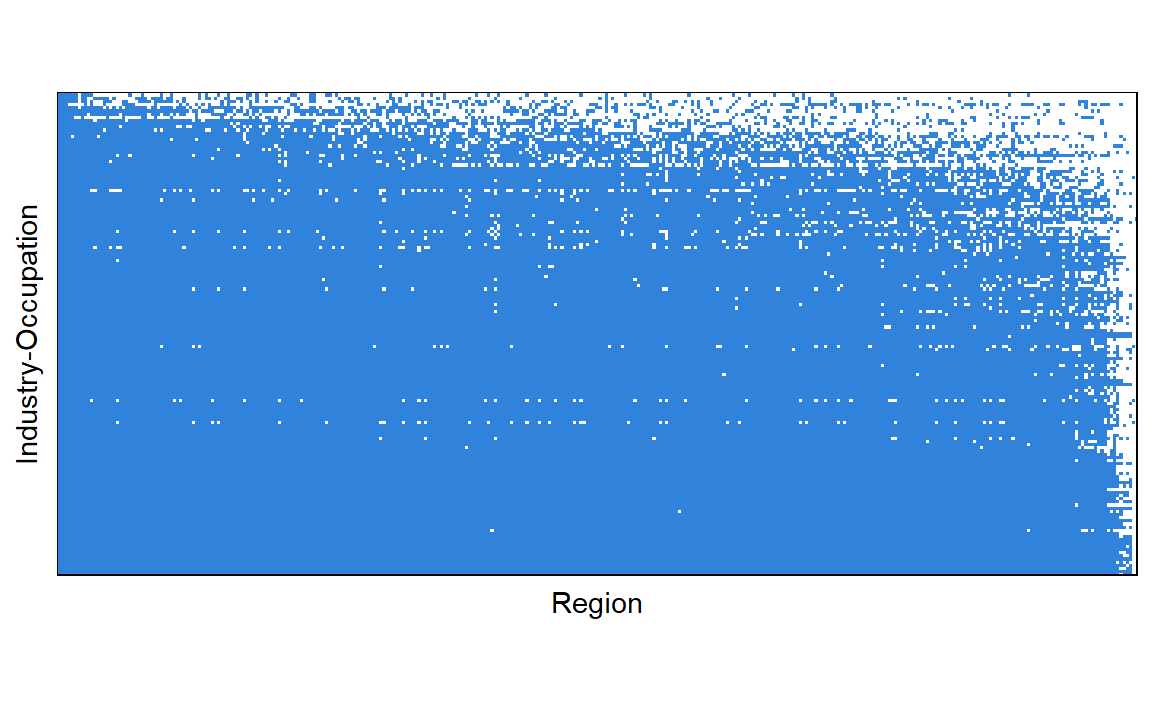

In [ ]:
pow_clean |> 
  mutate(presence = count > 0) |> 
  ggplot(aes(x = reorder(sa3, -sa3_size),
             y = reorder(industry_occupation, -industry_occupation_size),
             fill = presence)) +
  geom_raster() +
  labs(x = "Region",
       y = "Industry-Occupation") +
  scale_fill_manual(breaks = c(TRUE, FALSE),
                    values = c("#3182db", "white")) + 
  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.border = element_rect(fill = NA),
        legend.position = "none") + 
  coord_equal()

### Method

This section follows the method of @ecnz using correlations of employment shares rather than a location quotient method.

#### Relatedness

Activities are related based on the weighted correlation between the local activity share of employment, weighted by each regions share of total employment.

-   First calculate the weighted covariance

$$
cov_{aa} = \sum_{c \in C} (\frac{E_c^{a_i}}{E_c}-\frac{E^{a_i}}{E})(\frac{E_c^{a_j}}{E_c}-\frac{E^{a_j}}{E})
$$

-   Divide the weighted covariance by the city share-weighted standard deviations of the local activity shares to get the weighted correlation.

-   Map the correlation to the interval $[0,1]$ such that:

    $$
    r_{aa} = \frac{1}{2}(cor(a_i, a_j) + 1)
    $$

City relatedness is calculated symmetrically such that:

$$
r_{cc} = \frac{1}{2}(cor(c_i, c_j) + 1)
$$

#### Complexity

Activity complexity is defined by the second eigenvector of the matrix $r_{aa}$ and city complexity is defined by the second eigenvector of the matrix $r_{cc}$. The sign of activity complexity is set such that it is positively correlated with the weighted mean size of cities that contain activity $a$, and the sign of city complexity is set such that it is positively correlated with the local share-weighted mean complexity of activities in city $c$

In [ ]:
# function to calculate complexity from a region * activity matrix m

complexity_nz <- function(m, base_data) {
  
  activity_share <- m / rowSums(m)
  national_share_employment <- rowSums(m) / sum(m)
  
  # Relatedness of activities is the weighted covariance between the local share vectors for activities i and j, 
  # weighted by each regions share of total employment.
  
  
  r_aa <- 0.5*(cov.wt(x = activity_share, wt = national_share_employment, cor = TRUE)$cor + 1)
  
  
  #Complexity of activity a is the element a of the standardized second eigenvector of the row-standardized relatedness matrix r.
  complexity <- list()
  complexity$activity <- Re(eigen(r_aa/rowSums(r_aa))$vector[,2])
  complexity$activity  <- (complexity$activity  - mean(complexity$activity ))/sd(complexity$activity)
  names(complexity$activity) <- colnames(m)
  
  #Complexity is positively correlated with the weighted mean size of cities that contain activity a
  wmsc <- colSums(m/colSums(m)*rowSums(m))
  
  if (cor(complexity$activity , wmsc) < 0) {
    complexity$activity  = -1*complexity$activity
  } else complexity$activity  = complexity$activity 
  
  message(glue::glue("most complex activity: {names(complexity$activity[complexity$activity == max(complexity$activity)])}")) 
  
  
  # Relatedness of cities is symmetric to activities.
  city_share <- t(m / rowSums(m))
  national_share_activity <- colSums(m)/sum(m)
  r_cc <- 0.5*(cov.wt(x = city_share, wt = national_share_activity, cor = TRUE)$cor + 1)
  
  complexity$city <- Re(eigen(r_cc/rowSums(r_cc))$vector[,2])
  complexity$city <- (complexity$city- mean(complexity$city))/sd(complexity$city)
  names(complexity$city) <- rownames(m)
  
  #City complexity is positively correlated with the local share weighted mean complexity of activities in city c.
  wmc <- rowSums(m/colSums(m)*complexity$activity)
  
  if (cor(complexity$city, wmc) < 0 || complexity$city["Brisbane Inner"] < 0) {
    complexity$city = -1 * complexity$city
    } else complexity$city = complexity$city
  
  message(glue::glue("most complex city: {names(complexity$city[complexity$city == max(complexity$city)])}")) 
  
  df.complexity <- inner_join(base_data, enframe(complexity$city, name = "sa3", value = "city_complexity")) |> 
    inner_join(enframe(complexity$activity, name = "industry_occupation", value = "activity_complexity"))
  return(df.complexity)
}

## Results

In [ ]:
#|
m <- pow_clean |> 
  pivot_wider(id_cols = sa3,
              names_from = industry_occupation,
              values_from = count) |> 
  column_to_rownames(var = "sa3") |> 
  as.matrix()

complexity.df <- complexity_nz(m, base_data = pow_clean)

most complex activity: Professional, Scientific and Technical Services (Professionals)

most complex city: Brisbane Inner

Joining with `by = join_by(sa3)`
Joining with `by = join_by(industry_occupation)`

@fig-gcc-complexity shows the regional complexity of SA3 regions in Australian Greater Capital City Areas based on 2021 Census data. Complexity is highest in capital cities and surrounding regions.

Reading sa32021 file found in data

Variable(s) "fill" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.

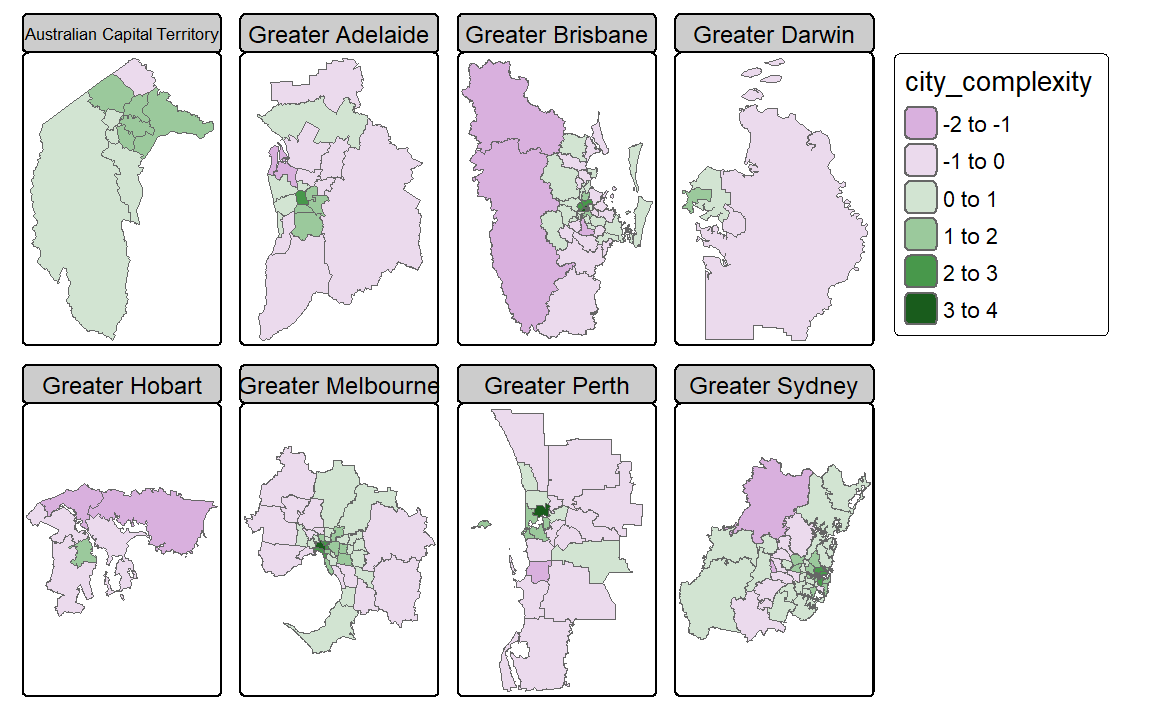

In [ ]:
city_complexity <- complexity.df |> 
  distinct(sa3, city_complexity) |> 
  left_join(read_absmap("sa32021",
                        export_dir = "data"),
            by = c("sa3" = "sa3_name_2021")) |> 
  st_as_sf()

### Spatial Correlation

-   Is economic complexity correlated across space?

In [ ]:
# first find the neighbours (using adacency)
nb <- poly2nb(city_complexity, queen = TRUE)
lw <- nb2listw(nb, style = "W", zero.policy = TRUE)

moranI <- moran(city_complexity$city_complexity, listw = lw, n = length(nb), S0 = Szero(lw))

moranIp <- moran.mc(city_complexity$city_complexity, lw, nsim = 1000)

-   Global Moran’s I = 0.5007756 with a p.value of 0.

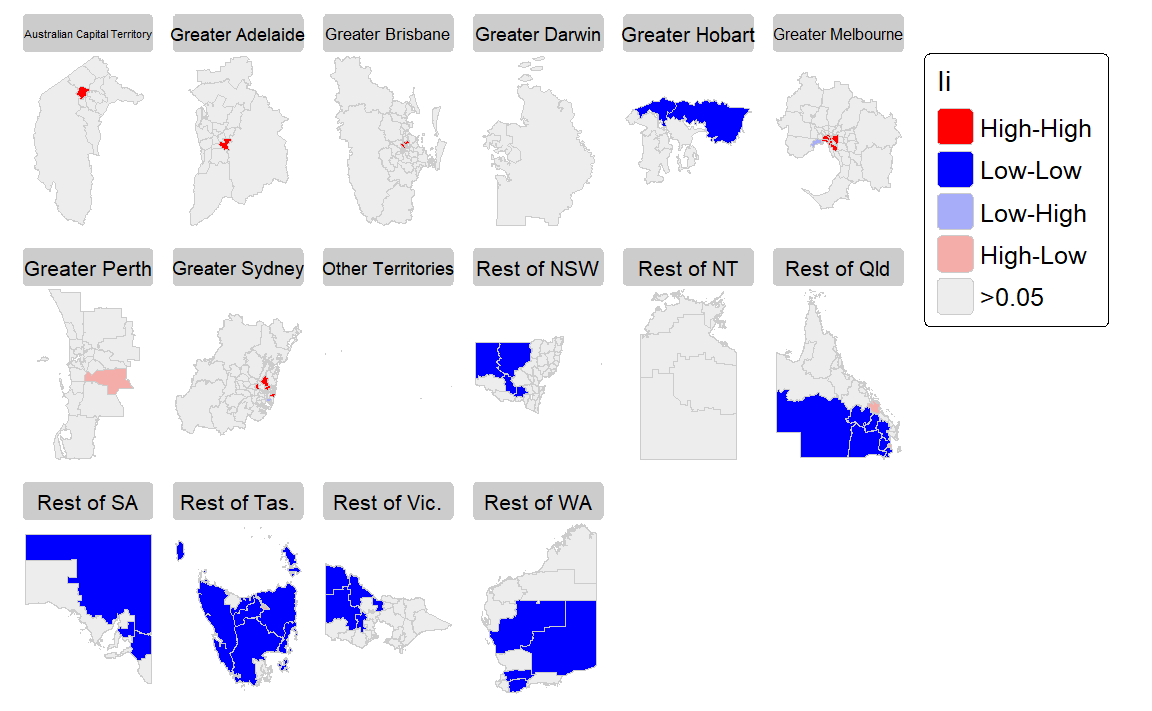

In [ ]:
MC.i <- localmoran_perm(city_complexity$city_complexity, lw, nsim = 9999) 

MC.i.df <- MC.i |> 
  as.data.frame() 

city_complexity$p <- MC.i.df$`Pr(folded) Sim`
city_complexity$Ii <- hotspot(MC.i, 
                              Prname = "Pr(folded) Sim", 
                              cutoff = 0.05, 
                              p.adjust = "fdr")
city_complexity$Ii <- factor(city_complexity$Ii, 
                             levels = c("High-High",
                                        "Low-Low",
                                        "Low-High", 
                                        "High-Low",
                                        ">0.05"))
city_complexity$Ii[is.na(city_complexity$Ii)] <- ">0.05"

pal2 <- c( "#FF0000", "#0000FF", "#a7adf9", "#f4ada8","#ededed")

tm_shape(city_complexity) + 
  tm_polygons(fill = "Ii",
              fill.scale = tm_scale_categorical(values = pal2),
              fill.legend = tm_legend(outside = TRUE, 
                                      text.size = 0.8),
              col = "grey80",
              lwd = 0.5) +
  tm_layout(frame = FALSE) + 
  tm_facets(by = "gcc_name_2021")

## Conclusion

## References